### Import the libraries

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# NLP libraries

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer


# Sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
from sklearn import svm


### Loading the dataset

In [2]:
test_df = pd.read_csv("/Users/shubham/Documents/BBS Electives/NLP/Coursework/test.csv")
train_df = pd.read_csv("/Users/shubham/Documents/BBS Electives/NLP/Coursework/train.csv")
test_labels = pd.read_csv("/Users/shubham/Documents/BBS Electives/NLP/Coursework/true_labels.csv")


In [3]:
train_df.head()

,label,text
0,0,Batch #5\n\nAppearance: Pours a slightly hazy ...
1,0,Murky peach color with off-white head. Aroma h...
2,0,Can poured into a Spiegelau IPA glass\n\nA: Po...
3,0,A big thanks to Jeff for this one. 750ml cappe...
4,0,On tap into a shaker pint.\n\nAppearance is go...


### Checking Null values

In [4]:
train_df.isnull().sum()

label    0
text     0
dtype: int64

### Checking class distribution

In [5]:
train_df['label'].value_counts()

label
0    7045
2    7029
1    6983
Name: count, dtype: int64

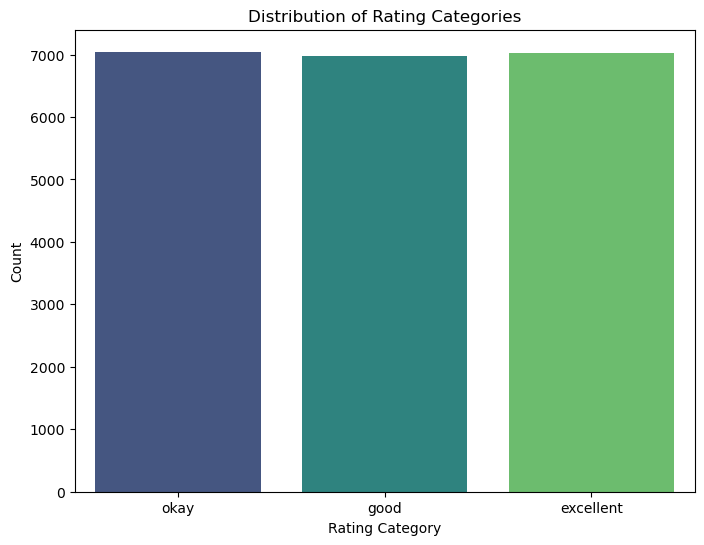

In [6]:
# Map the numeric labels to their corresponding category names
label_mapping = {0: 'okay', 1: 'good', 2: 'excellent'}
train_df['category'] = train_df['label'].map(label_mapping)

# Plot the distribution of classes
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='category', palette='viridis')
plt.title('Distribution of Rating Categories')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.show()

### Generating word cloud for each rating category 

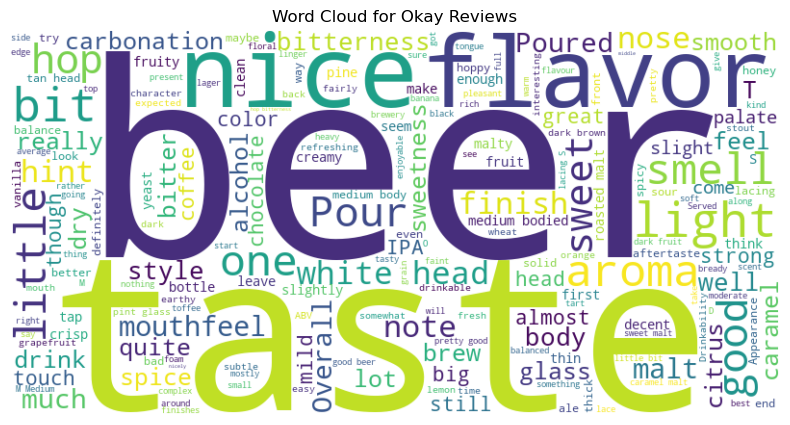

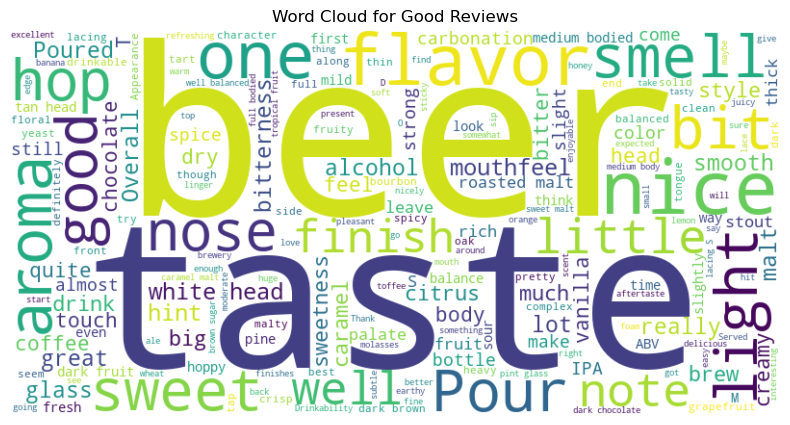

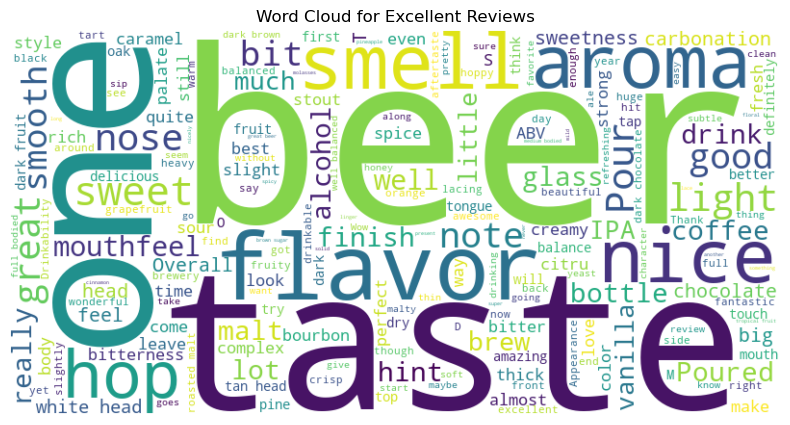

In [7]:
for label, category in label_mapping.items():
    text = " ".join(train_df[train_df['label'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category.capitalize()} Reviews')
    plt.axis('off')
    plt.show()


### Checking length of reviews

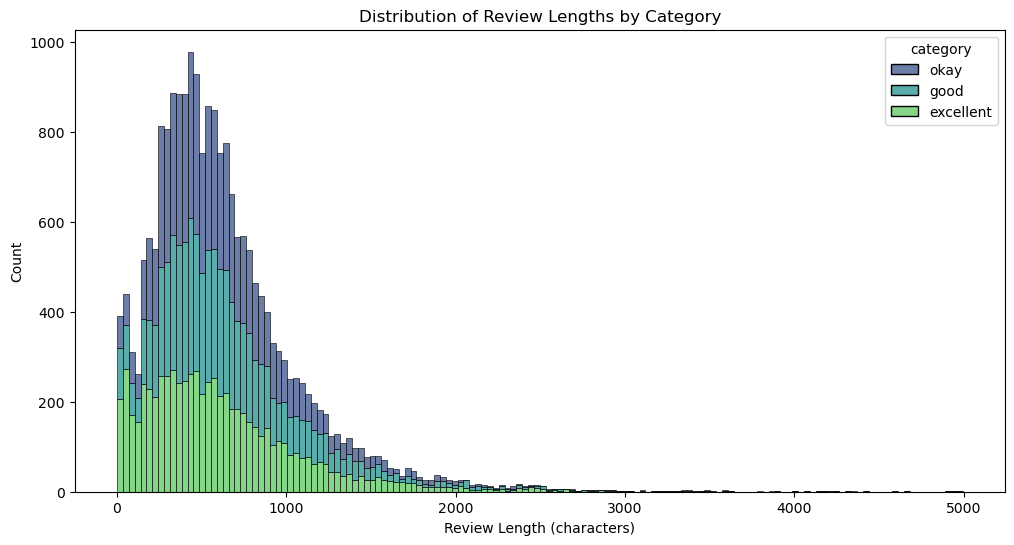

In [8]:
# Calculate the length of each review
train_df['review_length'] = train_df['text'].apply(len)

# Plot the distribution of review lengths for each category
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='review_length', hue='category', multiple='stack', palette='viridis')
plt.title('Distribution of Review Lengths by Category')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.show()

### Plotting top 20 two grams

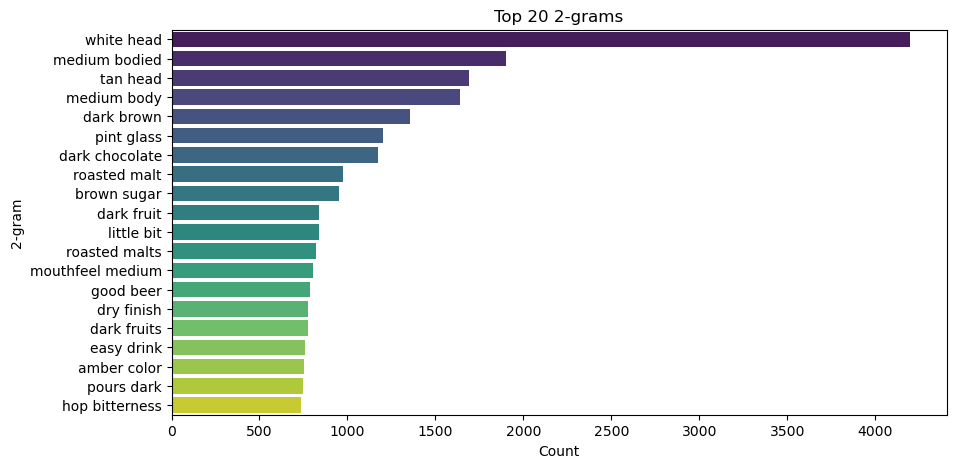

In [9]:

def plot_top_ngrams(texts, n=2, top_k=20):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]
    
    words, counts = zip(*words_freq)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Top {top_k} {n}-grams')
    plt.xlabel('Count')
    plt.ylabel(f'{n}-gram')
    plt.show()

plot_top_ngrams(train_df['text'], n=2, top_k=20)

### Correlation between Review length and Label -  Showing negligible correlation

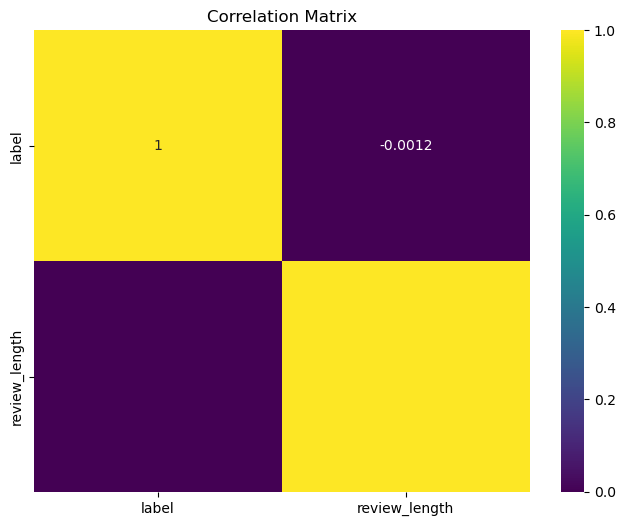

In [10]:
corr_matrix = train_df[['label', 'review_length']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()


### Data Preprocessing : Lowercasing, Stop word Removal, Tokenization, Lemmatization

In [11]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [12]:
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

### Split Data into Train and Validation Set

In [13]:
X = train_df['cleaned_text']
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

### TF-IDF Vectorization and Data Transformation


In [14]:
vectorizer = TfidfVectorizer(max_features= 5000)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# Test data

X_test_vec = vectorizer.transform(test_df['cleaned_text'])
y_test = test_labels['label']


### ML Classifiers

#### Logistic Regression


In [15]:
model_lr = LogisticRegression(penalty='l2', max_iter = 10000, random_state=0)
model_lr.fit(X_train_vec, y_train)

LogisticRegression(max_iter=10000, random_state=0)

#### Multinomial NB

In [16]:
model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)

MultinomialNB()

#### Support Vector Machine

In [17]:
model_svm = svm.SVC()
model_svm.fit(X_train_vec, y_train)

SVC()

In [18]:
svm_predictions = model_svm.predict(X_test_vec)
svm_predictions

array([0, 1, 1, ..., 1, 0, 2])

#### Functions to evaluate validation and test data

In [19]:
def evaluate_validation_data(model, X_val, y_val, model_name):
    val_preds = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)
    val_precision = precision_score(y_val, val_preds, average='macro')
    val_recall = recall_score(y_val, val_preds, average='macro')
    val_f1 = f1_score(y_val, val_preds, average='macro')

    print(f'{model_name} Validation Accuracy: {val_accuracy}')
    print(f'{model_name} Validation Precision: {val_precision}')
    print(f'{model_name} Validation Recall: {val_recall}')
    print(f'{model_name} Validation F1 Score: {val_f1}')


In [20]:
def evaluate_test_data(model, X_test, y_test, model_name):
    test_preds = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_precision = precision_score(y_test, test_preds, average='macro')
    test_recall = recall_score(y_test, test_preds, average='macro')
    test_f1 = f1_score(y_test, test_preds, average='macro')

    print(f'{model_name} Test Accuracy: {test_accuracy}')
    print(f'{model_name} Test Precision: {test_precision}')
    print(f'{model_name} Test Recall: {test_recall}')
    print(f'{model_name} Test F1 Score: {test_f1}')

#### Validation Results

In [21]:
models = {
    'Naive Bayes': model_nb,
    'Logistic Regression': model_lr,
    'Support Vector Machine': model_svm
}

for model_name, model in models.items():
    print(f'Evaluating {model_name}...')
    evaluate_validation_data(model, X_val_vec, y_val, model_name)


Evaluating Naive Bayes...
Naive Bayes Validation Accuracy: 0.5861823361823362
Naive Bayes Validation Precision: 0.5777916262866403
Naive Bayes Validation Recall: 0.5894977466589014
Naive Bayes Validation F1 Score: 0.5798903190207537
Evaluating Logistic Regression...
Logistic Regression Validation Accuracy: 0.5985280151946819
Logistic Regression Validation Precision: 0.5918482505854162
Logistic Regression Validation Recall: 0.6017028919782099
Logistic Regression Validation F1 Score: 0.5946833307068548
Evaluating Support Vector Machine...
Support Vector Machine Validation Accuracy: 0.6054131054131054
Support Vector Machine Validation Precision: 0.6004333390134707
Support Vector Machine Validation Recall: 0.6082961156663985
Support Vector Machine Validation F1 Score: 0.6031289901402397


#### Test Results

In [22]:
for model_name, model in models.items():
    print(f'Evaluating {model_name}...')
    evaluate_test_data(model, X_test_vec, y_test, model_name)

Evaluating Naive Bayes...
Naive Bayes Test Accuracy: 0.5836967460583696
Naive Bayes Test Precision: 0.576078609017277
Naive Bayes Test Recall: 0.5848603315175533
Naive Bayes Test F1 Score: 0.5782484299595824
Evaluating Logistic Regression...
Logistic Regression Test Accuracy: 0.5990159901599016
Logistic Regression Test Precision: 0.5919458754099858
Logistic Regression Test Recall: 0.6001219452133346
Logistic Regression Test F1 Score: 0.5946207435717311
Evaluating Support Vector Machine...
Support Vector Machine Test Accuracy: 0.6076260762607626
Support Vector Machine Test Precision: 0.6029052946628717
Support Vector Machine Test Recall: 0.6085952818370234
Support Vector Machine Test F1 Score: 0.6050487202392661


#### Plotting test results

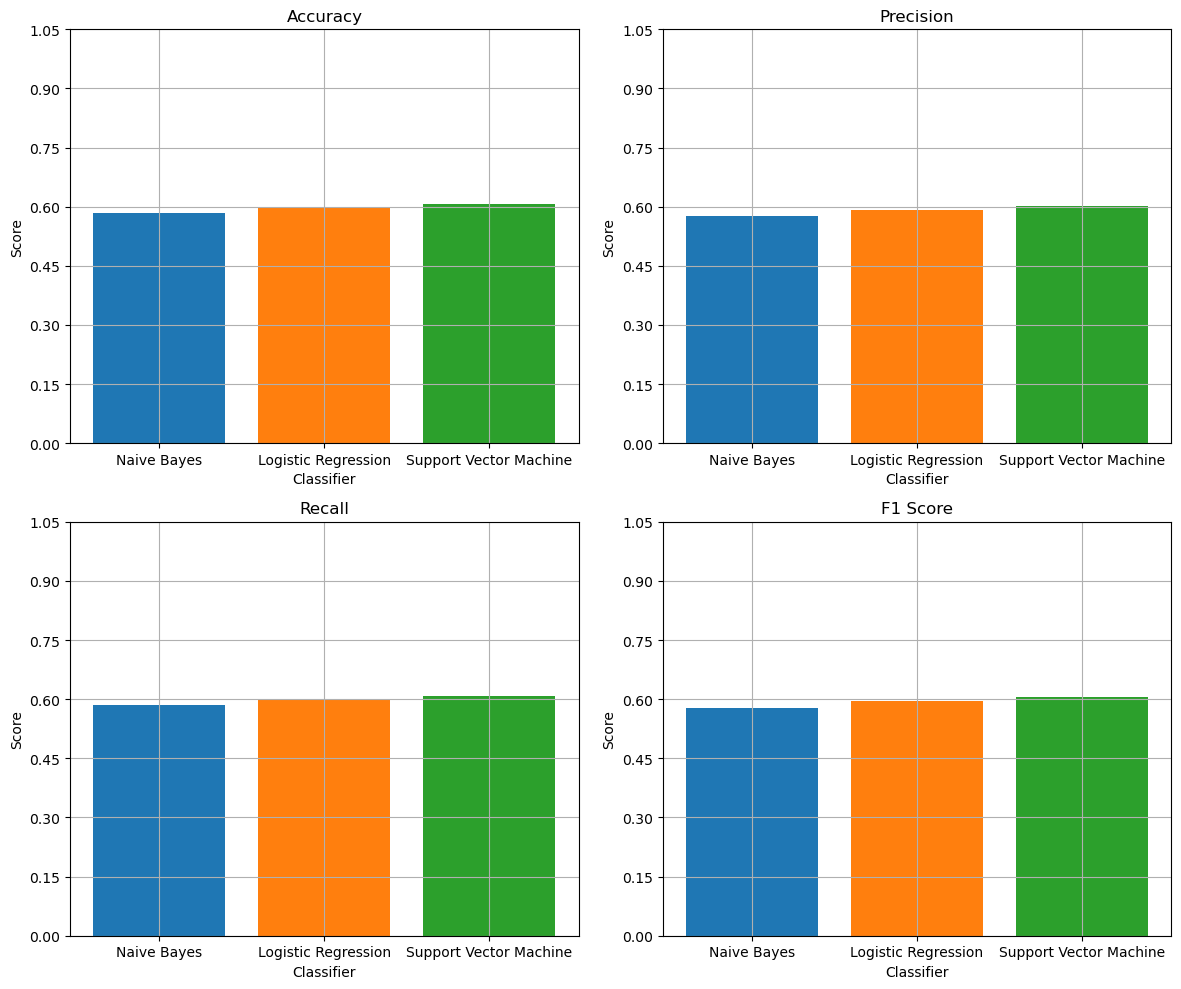

In [23]:
test_results = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for model_name, model in models.items():
    test_preds = model.predict(X_test_vec)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_precision = precision_score(y_test, test_preds, average='macro')
    test_recall = recall_score(y_test, test_preds, average='macro')
    test_f1 = f1_score(y_test, test_preds, average='macro')

    test_results['Accuracy'].append(test_accuracy)
    test_results['Precision'].append(test_precision)
    test_results['Recall'].append(test_recall)
    test_results['F1 Score'].append(test_f1)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 


for i, metric in enumerate(metrics):
    ax[i//2, i%2].bar(models.keys(), test_results[metric], color=colors)
    ax[i//2, i%2].set_title(metric)
    ax[i//2, i%2].set_ylim(0, 1)
    ax[i//2, i%2].set_yticks(np.arange(0, 1.1, 0.15))
    ax[i//2, i%2].set_ylabel('Score')
    ax[i//2, i%2].set_xlabel('Classifier')
    ax[i//2, i%2].grid(True)

plt.tight_layout()
plt.show()

#### Preparing Submission CSV

In [24]:
submission = pd.read_csv("/Users/shubham/Documents/BBS Electives/NLP/Coursework/submission.csv")

# Update the 'pred label' column with SVM predictions
submission['pred_label'] = svm_predictions

submission.to_csv("/Users/shubham/Documents/BBS Electives/NLP/Coursework/submission.csv", index=False)